# Configuração inicial e bibliotecas que serão utilizadas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
%matplotlib inline

In [2]:
test = pd.read_csv('../input/titanic/test.csv')
train = pd.read_csv('../input/titanic/train.csv')

# **3- Preparação dos Dados**




## **3.1 - Juntando os datasets de treino e teste**

Juntamos os dados para fazer as features engineering e depois separamos no final.

Se não quiser reunir tudo em um só dataset, então os mesmos tratamentos realizados no dataset train deverá também ser realizado no test. A vantagem juntar os datasets é que usaremos outras funções do pandas e com isso adquirimos familiaridade, como a função pd.concat().

In [3]:
# Salvanso os índices para separar os datasets no final
train_index= train.shape[0]
test_index = test.shape[0]
test_index

418

In [4]:
#Salvar o Passenger Id para subimissão no Kaglgle
passengerId = test.PassengerId

In [5]:
#Extrair a coluna Survived e excluí-la do treino

target = train.Survived.copy()

train.drop(columns=['Survived'], inplace=True)

train.head()#confirmando a exclusão

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# juntando treino e teste em um único DataFrame

tudo_junto = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

display(tudo_junto.shape)

(1309, 11)

## **3.2 - Selecionando as features**

Alguns dados não serão importantes para a construção do modelo como nem os notamos na Análise Exploratória. Então iremos excluí-los. 

No caso são: ['PassengerId', 'Name', 'Ticket', 'Cabin']

In [7]:
tudo_junto.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
tudo_junto.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


## **3.3 - Tratando os valores faltantes**

Normalmente preenchemos os dados faltantes com algum critério ou os excluímos. 
Se os dados faltantes forem menos que 5% do dataset então excluir é uma solução rápida, mas se for maior que isso corre-se o risco de perder dados e influencia a criação do modelo e o resultados das predições.

Vejamos.


In [8]:
tudo_junto.isna().sum()

Pclass        0
Sex           0
Age         263
SibSp         0
Parch         0
Fare          1
Embarked      2
dtype: int64

In [9]:
tudo_junto.isna().sum()/tudo_junto.shape[0] *100

Pclass       0.000000
Sex          0.000000
Age         20.091673
SibSp        0.000000
Parch        0.000000
Fare         0.076394
Embarked     0.152788
dtype: float64

Na idade e tarifa podemos completar os dados faltantes com a mediana ou a média, optamos pela mediana, já no caso do local de embarque optamos pelo porto de maior frequência.
Note que poderíamos optar por excluir os dados faltantes em Fare e Embarked, uma vez que representam menos de 1% dos dados totais. Já na variável idade, os dados faltantes são representativos: 20%, e sua exclusão poderia ocorrer perdas significativas de informações.

In [10]:
#idade - Escolhemos completar os valores nulos com a mediana, mas poderia ser a moda também.
tudo_junto.Age.fillna(tudo_junto.Age.median(), inplace=True)

In [11]:
#Tarifa - Também escolhemos preencher com a mediana
tudo_junto.Fare.fillna(tudo_junto.Fare.median(),inplace=True)


In [12]:
#Local de Embarque - Preenchemos com o local onde teve maior número de embarques.
tudo_junto.Embarked.fillna(tudo_junto.Embarked.value_counts()[0],inplace=True)

In [13]:
#Conferindo que não há mais valores nulos.
tudo_junto.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

## **3.4 - Preparando as variáveis para os modelos**

As variáveis de entrada para o modelo devem ser numéricas, portanto as categóricas terão que ser representadas desse modo:
- para Sex faremos 0 para male e 1 para female
- e para o local de embaque usaremos os dummies, isto é: 
- - se o passageiro embarcou no porto A, então recebe valor 1 para A e 0 para os demais portos; 
- - se embarcou no B recebe 1 para B e 0 nos demais;
- - se embarcou no C recebe 1 para C e 0 nos demais;

In [14]:
# COnvertendo Sex 0 para male e 1 para female

tudo_junto.Sex = tudo_junto.Sex.map({"male":0 , "female":1})

tudo_junto.Sex

0       0
1       1
2       1
3       1
4       0
       ..
1304    0
1305    1
1306    0
1307    0
1308    0
Name: Sex, Length: 1309, dtype: int64

In [15]:
# dummies variables para Embarked
embarked_dummies = pd.get_dummies(tudo_junto.Embarked, prefix='Embarked')

tudo_junto = pd.concat([tudo_junto, embarked_dummies], axis=1)
                      

In [16]:
tudo_junto

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_914,Embarked_C,Embarked_Q,Embarked_S
0,3,0,22.0,1,0,7.2500,S,0,0,0,1
1,1,1,38.0,1,0,71.2833,C,0,1,0,0
2,3,1,26.0,0,0,7.9250,S,0,0,0,1
3,1,1,35.0,1,0,53.1000,S,0,0,0,1
4,3,0,35.0,0,0,8.0500,S,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,28.0,0,0,8.0500,S,0,0,0,1
1305,1,1,39.0,0,0,108.9000,C,0,1,0,0
1306,3,0,38.5,0,0,7.2500,S,0,0,0,1
1307,3,0,28.0,0,0,8.0500,S,0,0,0,1


In [17]:
tudo_junto.drop(columns=['Embarked'], inplace=True)

In [18]:
tudo_junto

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_914,Embarked_C,Embarked_Q,Embarked_S
0,3,0,22.0,1,0,7.2500,0,0,0,1
1,1,1,38.0,1,0,71.2833,0,1,0,0
2,3,1,26.0,0,0,7.9250,0,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1
4,3,0,35.0,0,0,8.0500,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1304,3,0,28.0,0,0,8.0500,0,0,0,1
1305,1,1,39.0,0,0,108.9000,0,1,0,0
1306,3,0,38.5,0,0,7.2500,0,0,0,1
1307,3,0,28.0,0,0,8.0500,0,0,0,1


## **3.5 - Separando os datasets de treino e teste**

Agora que já tratamos os dados podemos separar  os datasets como  eram no inicio e começaremos contruir nossos modelos e comparálos.


In [19]:
train = tudo_junto.iloc[:train_index]
test = tudo_junto.iloc[train_index:]

# **4 - Construção do Modelos e Avaliação**

Nos modelos abaixo, há um briefing sobre seu funcionamento e  indicação de artigos sobre o assunto e a blioteca consultada.

Depois de calculada a acurácia, o arquivo csv de predição para submissão no Kaggle é gerado e uma comparação das performances é mostrada.

Antes de tudo, foi criada uma função simples com o objetivo de armazenar, classificar e exibir a performance de cada modelo.

In [20]:
comparacao_modelos = pd.DataFrame(columns=['Modelo', 'Acurácia']) # Esse Data Frame tem o objetivo de armazenar os valores das métricas para facilitar a comparação dos valores.

In [21]:
#essa função armazenará, classificará por ordem de melhor desempenho o nome do modelo e sua acurácia.
def comparar(Nome_do_modelo, valor_acuracia):  

  global comparacao_modelos

  comparacao_modelos = comparacao_modelos.append({'Modelo': Nome_do_modelo, 'Acurácia': valor_acuracia }, ignore_index=True)

  #Colocando em ordem de melhor acurácia para a pior

  comparacao_modelos.sort_values(ascending=False, by='Acurácia', inplace=True)

  comparacao_modelos.drop_duplicates(inplace=True) # para caso duplicar uma linha sem querer :)

  display(comparacao_modelos) 

In [22]:
#a semente para que as amostram sejam as mesmas
SEED = 2021
np.random.seed(SEED)

## **4.1 - Dummy Classifier**
O Dummy Classifier, foi o primeiro a ser escolhido já que é usado para ter uma base de performance dos modelos e suas regras de classificação são simples. Não é indicado para problemas reais.
Por exemplo, ele pode chutar todos valores 0 ou 1 e com isso ter uma acurácia alta mas isso não quer dizer que prediz alguma coisa. 

[What is the scikit-learn dummy classifier?](https://medium.com/@mamonu/what-is-the-scikit-learn-dummy-classifier-95549d9cd44)

[Biblioteca](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)

In [23]:
from sklearn.dummy import DummyClassifier

dummy_stratified = DummyClassifier(strategy = 'most_frequent', random_state = SEED) #testei os parâmetro strategy e mantive o que obtém o melhor resultado

dummy_stratified.fit(train, target)

DummyClassifier(random_state=2021, strategy='most_frequent')

In [24]:
#verificando a acurácia do modelo
acuracia_dummy = round(dummy_stratified.score(train, target)*100, 2)

display(f"A acurácia do modelo Dummy Classifier é de {acuracia_dummy} %")

'A acurácia do modelo Dummy Classifier é de 61.62 %'

In [25]:
comparar("Dummy Classifier",acuracia_dummy)

,Modelo,Acurácia
0,Dummy Classifier,61.62


## **4.2 - Modelo de Regressão Logística**
É um modelo popular usado em problemas de classificação cuja a variável alvo é categórica e tem dois possíveis resultados, p.e, 0 ou 1. No nosso caso, se sobreviveu (1) ou não sobreviveu (0).

[Logistic Regression — Detailed Overview](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc)

[Biblioteca](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic%20regression#sklearn.linear_model.LogisticRegression)

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
#criando  o modelo
lr_model = LogisticRegression(solver='liblinear',random_state=SEED)
lr_model.fit(train, target)

LogisticRegression(random_state=2021, solver='liblinear')

In [28]:
#verificando a acurácia do modelo
acuracia_r_l = round(lr_model.score(train, target)*100, 2)

display(f"A acurácia do modelo de Regressão Logística é de {acuracia_r_l} %")

'A acurácia do modelo de Regressão Logística é de 80.13 %'

In [29]:
#Gerando a previsão com os testes

y_predict = lr_model.predict(test)

#submission = pd.DataFrame({'PassengerId': passengerId,'Survived':y_predict})

In [30]:
#gerando o arquivo Csv
#submission.to_csv('./submission_lr.csv', index=False)


In [31]:
comparar('Regressão Logística', acuracia_r_l)

,Modelo,Acurácia
1,Regressão Logística,80.13
0,Dummy Classifier,61.62


* ## **4.3 - Modelo de Árvore de Decisão**
Algoritmos de Árvode de Decisão são métodos populares usados para regressão e classificação. 
O algritmo é baseado no precedimento de 'nó', isto é, em cada nó é feita a pergunta se pertence a 'x' ou 'y' que se tornam os nós x e y. O procedimento é realizado em x e y que por sua vez irão gerar mais 2 nós cada um. Já percebeu que o processo é exponencial né? Quanto maior a quantidade de nós, maior a profundidade da árvore o que a torna mais complexa. o parâmetro max_depth limita a profundidade da árvore.


[Modelos de Predição | Decision Tree](https://medium.com/turing-talks/turing-talks-17-modelos-de-predi%C3%A7%C3%A3o-decision-tree-610aa484cb05)

[Biblioteca](https://scikit-learn.org/stable/modules/tree.html#tree)


In [32]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
#Criando o modelo
tree_model = DecisionTreeClassifier(max_depth=3, random_state=SEED)

tree_model.fit(train,target)

DecisionTreeClassifier(max_depth=3, random_state=2021)

In [34]:
#verificando a acurácia do modelo
acuracia_tree_model = round(tree_model.score(train, target)*100, 2)

display(f"A acurácia do modelo de Árvore de Classificação é de {acuracia_tree_model} %")

'A acurácia do modelo de Árvore de Classificação é de 82.72 %'

In [35]:
y_pred_tree = tree_model.predict(test)

submission = pd.DataFrame({
    "PassengerId": passengerId,
    "Survived": y_pred_tree
})

# gerar arquivo csv
submission.to_csv('./submission_tree.csv', index=False)

In [36]:
comparar( "Decision Tree Classifier", acuracia_tree_model)

,Modelo,Acurácia
2,Decision Tree Classifier,82.72
0,Regressão Logística,80.13
1,Dummy Classifier,61.62


## **4.4 - Modelo de Regressão Linear**


In [37]:
from sklearn.linear_model import LinearRegression

In [38]:
#criando o modelo
linear_model = LinearRegression()
linear_model.fit(train,target)

LinearRegression()

In [39]:
#verificando a acurácia do modelo
acuracia_linear_regression = round(linear_model.score(train, target)*100, 2)

display(f"A acurácia do modelo de Linear é de {acuracia_linear_regression} %")

'A acurácia do modelo de Linear é de 39.79 %'

In [40]:
comparar("Linear Regression", acuracia_linear_regression)

,Modelo,Acurácia
0,Decision Tree Classifier,82.72
1,Regressão Logística,80.13
2,Dummy Classifier,61.62
3,Linear Regression,39.79


**O modelo de Regressão Linear definitivamente não é bom para esse tipo de problema, vimos que com o Dummy Classifier obtemos um resutado melhor.**

## **4.5 - Gradient Boosting ClassiFier**
É um conjunto de modelos mais fracos que combinados conseguem fazer uma predição mais robusta. Os artigos dão uma ideia muito melhor do funcionamento desses algoritmos.

[What’s a gradient boosting classifier?](https://medium.com/codestory/gradient-boosting-classifier-f7a6834979d8)


[Um tutorial completo sobre modelagem baseada em árvores de decisão (códigos R e Python)](https://www.vooo.pro/insights/um-tutorial-completo-sobre-a-modelagem-baseada-em-tree-arvore-do-zero-em-r-python/)

[Biblioteca](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gradient%20boost%20classifier#sklearn.ensemble.GradientBoostingClassifier)

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

In [42]:
#criando o modelo
gradient_model = GradientBoostingClassifier(max_depth=3, learning_rate=0.3, random_state=SEED)

gradient_model.fit(train,target)

GradientBoostingClassifier(learning_rate=0.3, random_state=2021)

In [43]:
#verificando a acurácia do modelo
acuracia_gradient = round(gradient_model.score(train, target)*100, 2)

display(f"A acurácia do modelo de Gradiente é de {acuracia_gradient} %")

'A acurácia do modelo de Gradiente é de 94.39 %'

In [44]:
#gerando as previsões
y_pred_gradient = gradient_model.predict(test)

submission = pd.DataFrame({
    "PassengerId": passengerId,
    "Survived": y_pred_gradient
})

# gerar arquivo csv
submission.to_csv('./submission_gradient.csv', index=False)

In [45]:
comparar("Gradient Boosting Model", acuracia_gradient)

,Modelo,Acurácia
4,Gradient Boosting Model,94.39
0,Decision Tree Classifier,82.72
1,Regressão Logística,80.13
2,Dummy Classifier,61.62
3,Linear Regression,39.79


## **4.6 - Random Forest Classifier**

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
#criando o Modelo
random_forest_model = RandomForestClassifier(n_estimators=55, random_state=SEED)
random_forest_model.fit(train, target)

RandomForestClassifier(n_estimators=55, random_state=2021)

In [48]:
#verificando a acurácia do modelo
acuracia_random_forest = round(random_forest_model.score(train, target)*100, 2)

display(f"A acurácia do modelo Random Forest é de {acuracia_random_forest} %")

'A acurácia do modelo Random Forest é de 97.98 %'

In [49]:
#gerando as previsões
y_pred_random_forest = random_forest_model.predict(test)

submission = pd.DataFrame({
    "PassengerId": passengerId,
    "Survived": y_pred_random_forest
})

# gerar arquivo csv
submission.to_csv('./submission_random_forest.csv', index=False)

In [50]:
comparar("Random Forest Classifier", acuracia_random_forest)

,Modelo,Acurácia
5,Random Forest Classifier,97.98
0,Gradient Boosting Model,94.39
1,Decision Tree Classifier,82.72
2,Regressão Logística,80.13
3,Dummy Classifier,61.62
4,Linear Regression,39.79


**UAU!! 97,98% é um resultado incrível!! Será que há algo errado?**

## **4.7 - Modelo XGB Classifier**

In [51]:
from xgboost import XGBClassifier

In [52]:
xgbc_model = XGBClassifier(max_depth=15, min_child_weight=1, n_estimators=500, random_state=42, learning_rate=0.01,  
                     eval_metric=["error", "logloss"])
xgbc_model.fit(train, target)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_metric=['error', 'logloss'], gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
#verificando a acurácia do modelo
acuracia_XGB = round(xgbc_model.score(train, target)*100, 2)

display(f"A acurácia do modelo XGBC  é de {acuracia_XGB} %")

'A acurácia do modelo XGBC  é de 92.93 %'

In [54]:
#gerando as previsões
y_pred_xbgc = xgbc_model.predict(test)

submission = pd.DataFrame({
    "PassengerId": passengerId,
    "Survived": y_pred_xbgc
})

# gerar arquivo csv
submission.to_csv('./submission_xbgc.csv', index=False)

In [55]:
comparar('XGB Classifier',acuracia_XGB)

,Modelo,Acurácia
0,Random Forest Classifier,97.98
1,Gradient Boosting Model,94.39
6,XGB Classifier,92.93
2,Decision Tree Classifier,82.72
3,Regressão Logística,80.13
4,Dummy Classifier,61.62
5,Linear Regression,39.79


## **4.8 - Modelo SVC**


In [56]:
from sklearn.svm import SVC

In [57]:
#criando o Modelo
svc_model = SVC(C=10000, random_state=SEED)
svc_model.fit(train, target)

SVC(C=10000, random_state=2021)

In [58]:
#verificando a acurácia do modelo
acuracia_svc = round(svc_model.score(train, target)*100, 2)

display(f"A acurácia do modelo SVC  é de {acuracia_svc} %")

'A acurácia do modelo SVC  é de 84.18 %'

In [59]:
#gerando as previsões
y_pred_svc = svc_model.predict(test)

submission = pd.DataFrame({
    "PassengerId": passengerId,
    "Survived": y_pred_svc
})

# gerar arquivo csv
submission.to_csv('./submission_svc.csv', index=False)

In [60]:
comparar('SVC', acuracia_svc)

,Modelo,Acurácia
0,Random Forest Classifier,97.98
1,Gradient Boosting Model,94.39
2,XGB Classifier,92.93
7,SVC,84.18
3,Decision Tree Classifier,82.72
4,Regressão Logística,80.13
5,Dummy Classifier,61.62
6,Linear Regression,39.79


## **4.9 - Modelo KNeighbor**

In [61]:
from sklearn.neighbors import KNeighborsClassifier

In [62]:
#Criando o modelo
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(train, target)

KNeighborsClassifier(n_neighbors=2)

In [63]:
#verificando a acurácia do modelo
acuracia_knn = round(knn_model.score(train, target)*100, 2)

display(f"A acurácia do modelo KNeighborsClassifier  é de {acuracia_knn} %")

'A acurácia do modelo KNeighborsClassifier  é de 84.51 %'

In [64]:
#gerando as previsões
y_pred_knn= knn_model.predict(test)

submission = pd.DataFrame({
    "PassengerId": passengerId,
    "Survived": y_pred_knn
})

# gerar arquivo csv
submission.to_csv('./submission_knn.csv', index=False)

In [65]:
comparar('KNeighbors Classifier', acuracia_knn)

,Modelo,Acurácia
0,Random Forest Classifier,97.98
1,Gradient Boosting Model,94.39
2,XGB Classifier,92.93
8,KNeighbors Classifier,84.51
3,SVC,84.18
4,Decision Tree Classifier,82.72
5,Regressão Logística,80.13
6,Dummy Classifier,61.62
7,Linear Regression,39.79


## **4.10 - Comparando os modelos**

Agora que comparamos a acurácia dos modelos e colocamos em ordem decrescente, temos uma noção dos que possuem melhor desempenho.

Lembrando que as Acurácias são dos dados de treino, o que não quer dizer que eles terão o mesmo resultado nos dados de teste e 'real life'.
A partir de agora usaremos os 3 modelos que se destacam para analisar  com   outros métodos: MAtriz de Confusão, e Validação Cruzada.

Para saber mais, indico esse artigo em inglês: [Performance Metrics in ML- Part 1](https://towardsdatascience.com/performance-metrics-in-machine-learning-part-1-classification-6c6b8d8a8c92).

In [66]:
tres_modelos = comparacao_modelos[:3].copy()
tres_modelos

,Modelo,Acurácia
0,Random Forest Classifier,97.98
1,Gradient Boosting Model,94.39
2,XGB Classifier,92.93


# **5 - Matriz de Confusão, Precisão, Recall, e F1-Score**

Nesta seção calculamos e plotamos os gráficos da Matriz de Confusão. As funções zip e flatten  são brevemente explicadas, também indicamos um vídeo explicativo sobre o list conprehension.
Os gráficos também poderiam ser plotados por meio de uma função. Optei por plotar as imagens lado a lado para facilitar a comparação dos resultados.


## 5.1 - **Matriz de Confusão** 
é uma matriz/tabela  n x n onde n é o número de ***classes/categorias*** da variável alvo - ***target***. No caso do Titanic a variável alvo posui duas categorias: ***0*** se não sobreviveu e ***1*** se sobreviveu.
Nos plots são mostrados 4 quadrantes descritos a seguir:


*   **Verdadeiro Positivo ou True Positive - TP** : Quando o modelo prevê corretamente a variável alvo,p.e,  previu que um passageiro sobreviveria e sobreviveu. (1,1)
*   **Falso Positivo ou False Positive - FP:** quando o modelo prevê incorretamente a classe alvo, p.e, previu que o passageiro sobreviveiria mas não sobreviveu,(1,0). Também é conhecido como ***Erro do tipo 1***
*   **Verdadeiro Negativo ou True Negative - TN:** Quando o modelo prevê corretamente que não pertence a categoria que estamos tentando prever, p.e, previu que não sobreviveria e não sobreviveu. (0,0)
*   **Falso Negativo ou False Negative - FN** : Quando o modelo prevê incorretamente que não pertence a clase alvo mas na verdade pertence, p.e, que não sobreviveria mas sobreviveu, (0,1). Também é conhecido como ***Erro do tipo 2***.

A **Acurácia**, que foi calculada na seção anterior para a escolha dos melhores modelos, é a medida de todas as previsões corretas feitas pelo modelo em relação a todas as previsões. 

***Acurácia*** = **(TP + TN) / (TP + TN + FP + FN)**

Para saber mais detalhes você pode acessar:

[Artigo em português](https://medium.com/data-hackers/entendendo-o-que-%C3%A9-matriz-de-confus%C3%A3o-com-python-114e683ec509)

[Artigo em Inglês](https://towardsdatascience.com/evaluation-metrics-18db24a91223)





In [67]:
from sklearn.metrics import confusion_matrix 

# Usamos os mesmos dados de treino para previsão e calculamos a matriz de confusão
xgbc_predict = xgbc_model.predict(train)
xgbc_matrix = confusion_matrix(target,xgbc_predict )

A **função flatten do pandas** retorna um array unidimensional.
Por exemplo:
a = [ [1,2], [3,4] ]

a.flatten()

retorna: 
[1,2,3,4]

Aqui nós a usamos para transformar o retorno da confusion_matrix em uma lista para na sequência aplicarmos a função zip.

A **Função zip do Python** retorna uma lista de tuplas de acordo com a posição. Por exemplo:
>a = [1,2]

>b = [4,5]

> zip(a,b)

Retorna:
(1,4) 
(2,5)

Aqui no código usamos para juntar em uma mesma tupla a classificação, contagem e percentual e posteriormente imprimir em cada quadrado do gráfico da matriz de confusão..





**List Comprehension**  é um jeito de construir uma lista com uma simples linha em Python. Substitui o padrão de criar uma lista vazia, preenchê-la com um loop através de ifs. 

Para entender melhor indico o vídeo a seguir mas há muitos outros disponíveis gratuitamente no youtube: [Vídeo](https://youtu.be/j7pe5x2apBs)

In [68]:
#Será impresso no gráfico

classificacao = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']

contagem_xgbc = ["{0:0.0f}".format(value) for value in xgbc_matrix.flatten()] # list comprehension  que irá gerar uma lista da Matriz de confusão.

percentual_xgbc = ["{0:.2%}".format(value) for value in xgbc_matrix.flatten()/np.sum(xgbc_matrix)] # list comprehension  que irá gerar uma lista com os % da Matriz de confusão.

labels_xgbc = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(classificacao,contagem_xgbc,percentual_xgbc)] #reúne as informações acima 

labels_xgbc = np.asarray(labels_xgbc).reshape(2,2) # remodela o array unidimendional em um 2x2 que será impresso em cada quadrante da Matriz de Confusão

print(classificacao)
display(contagem_xgbc)
display(percentual_xgbc)
display(labels_xgbc)

#sns.heatmap(xgbc_matrix, annot=labels_xgbc, fmt="", cmap='Blues') # gráfico da matriz de confusão individual. Preferi lotar os 3 lado a lado para facilitar a comparação

['Verdadeiro Negativo', 'Falso Positivo', 'Falso Negativo', 'Verdadeiro Positivo']


['529', '20', '43', '299']

['59.37%', '2.24%', '4.83%', '33.56%']

array([['Verdadeiro Negativo\n529\n59.37%', 'Falso Positivo\n20\n2.24%'],
       ['Falso Negativo\n43\n4.83%', 'Verdadeiro Positivo\n299\n33.56%']],
      dtype='<U30')

In [69]:
# COnfigurando o gráfico para o modelo Random Forest
random_predict = random_forest_model.predict(train)
random_matrix = confusion_matrix(target,random_predict )


classificacao = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']

contagem_rf = ["{0:0.0f}".format(value) for value in random_matrix.flatten()] # list comprehension

percentual_rf = ["{0:.2%}".format(value) for value in random_matrix.flatten()/np.sum(random_matrix)]

labels_rf = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(classificacao,contagem_rf,percentual_rf)]

labels_rf = np.asarray(labels_rf).reshape(2,2)

#sns.heatmap(random_matrix, annot=labels_rf, fmt="", cmap='Oranges')

In [70]:
# COnfigurando o gráfico para o modelo Gradient boost Model
gradient_predict = gradient_model.predict(train)
gradient_matrix = confusion_matrix(target,gradient_predict )


classificacao = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']

contagem_gb = ["{0:0.0f}".format(value) for value in gradient_matrix.flatten()] # list comprehension

percentual_gb = ["{0:.2%}".format(value) for value in gradient_matrix.flatten()/np.sum(gradient_matrix)]

labels_gb = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(classificacao,contagem_gb,percentual_gb)]

labels_gb = np.asarray(labels_gb).reshape(2,2)

#sns.heatmap(gradient_matrix, annot=labels_gb, fmt="", cmap='Greens')

Text(1188.7058823529412, 0.5, 'Real')

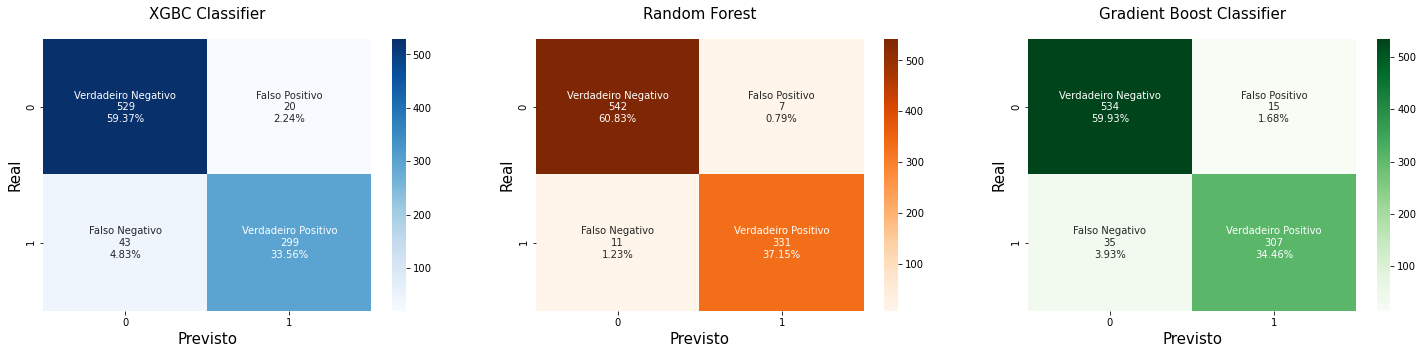

In [71]:
#colocando os gráficos lado a lado para facilitar a comparação
fig, (axis1, axis2, axis3) = plt.subplots(1,3, figsize=(25,5))

#matrix de confusão do XBGC
ax = sns.heatmap(xgbc_matrix, annot=labels_xgbc, fmt="", cmap='Blues', ax=axis1)
ax.set_title("XGBC Classifier", fontsize=15,pad=20)
ax.set_xlabel('Previsto', fontsize= 15)
ax.set_ylabel('Real', fontsize=15)

# #matrix de confusão do Random Forest
ax = sns.heatmap(random_matrix, annot=labels_rf, fmt="", cmap='Oranges', ax=axis2)
ax.set_title("Random Forest", fontsize=15,pad=20)
ax.set_xlabel('Previsto', fontsize= 15)
ax.set_ylabel('Real', fontsize=15)

#matrix de confusão do Gradient Boost
ax = sns.heatmap(gradient_matrix, annot=labels_gb, fmt="", cmap='Greens', ax=axis3)
ax.set_title("Gradient Boost Classifier", fontsize=15,pad=20)
ax.set_xlabel('Previsto', fontsize= 15)
ax.set_ylabel('Real', fontsize=15)



As relações adquirem relevância de acordo com o que se está querendo prever. 

Por exemplo, ao prever se um paciente está com alguma doença terminal em caso de não tratamento os **Falsos Negativos** são importantes, pois o paciente depende do tratamento para sobreviver mas o modelo retorna que ele não está doente, portanto com diagnóstico que pode levar a morte.

No caso do **Falso Positivo,** podemos citar uma empresa que quer saber o que manter em uma linha de produtos/serviços que trarão lucros, o modelo prevê que o item será lucrativo mas na verdade pode dar prejuízo para a empresa.


## **5.2 - Precisão**

Para superar as limitações da acurácia a **Precision**  nos fala qual a proporção de previsões positivas estão corretas.

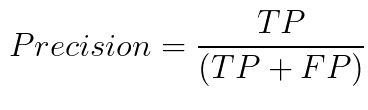

In [72]:
from sklearn.metrics import precision_score

In [73]:
tres_modelos

,Modelo,Acurácia
0,Random Forest Classifier,97.98
1,Gradient Boosting Model,94.39
2,XGB Classifier,92.93


In [74]:
#lista dos valores preditos respeitando a ordem  dos tres_modelos para inserir numa coluna e compararmos.
lista_val_predict =[random_predict,gradient_predict,xgbc_predict] 

In [75]:
tres_modelos['Precisão'] = [(precision_score(target,x)*100).round(2) for x in lista_val_predict]
tres_modelos

,Modelo,Acurácia,Precisão
0,Random Forest Classifier,97.98,97.93
1,Gradient Boosting Model,94.39,95.34
2,XGB Classifier,92.93,93.73


## **5.3 - Recall**

Semelhante a precisão, o **Recall = Sensitivity = True Positive Rate = Hit Rate** calcula qual a proporção de positivos foi identificada corretamente.

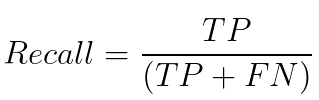

In [76]:
from sklearn.metrics import recall_score

tres_modelos['Recall']=[(recall_score(target,x)*100).round(2) for x in lista_val_predict]
tres_modelos

,Modelo,Acurácia,Precisão,Recall
0,Random Forest Classifier,97.98,97.93,96.78
1,Gradient Boosting Model,94.39,95.34,89.77
2,XGB Classifier,92.93,93.73,87.43


A curva **Precision-Recall** pode ser plotada como podemos ver abaixo para cada um dos modelos.

"*A curva de recall de precisão plota a relação entre precisão e RECALL à medida que o limite de decisão é alterado. Recall é a capacidade de um modelo detectar todos os exemplos positivos e a precisão é a capacidade de um modelo evitar rotular amostras negativas como positivas. Alguns problemas de negócios podem exigir uma recall mais alta e uma precisão mais alta, dependendo da importância relativa de evitar falsos negativos versus falsos positivos.*" Trecho retirado da documentação da Microsoft Azure.

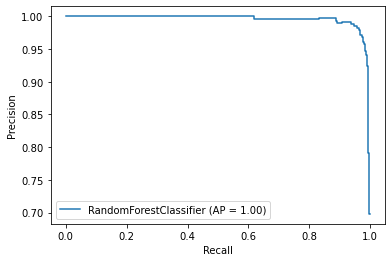

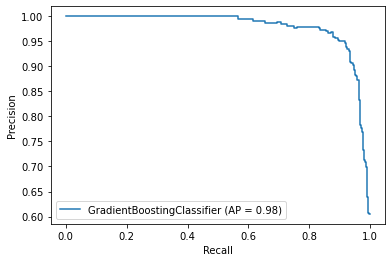

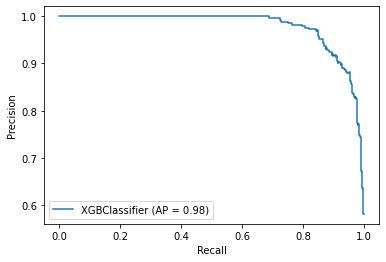

In [77]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(random_forest_model, train,target)
plot_precision_recall_curve(gradient_model, train, target)
plot_precision_recall_curve(xgbc_model, train, target)

## **5.4 - F1 - Score**
É uma média harmônica entre a Precisão e o Recall no intervalo entre 0 e 1

1 - Indica precisão e recall perfeitos

0 - Se precisão ou Recall for zero.

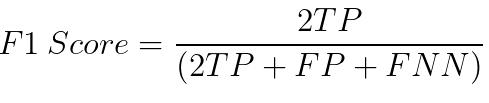

In [78]:
from sklearn.metrics import f1_score

In [79]:
tres_modelos['F1-Score'] = [(f1_score(target,x)*100).round(2) for x in lista_val_predict]
tres_modelos

,Modelo,Acurácia,Precisão,Recall,F1-Score
0,Random Forest Classifier,97.98,97.93,96.78,97.35
1,Gradient Boosting Model,94.39,95.34,89.77,92.47
2,XGB Classifier,92.93,93.73,87.43,90.47


## **5.5 - Obtendo todas as métricas por meio do classification_report**
Em vez de termos esse trabalho todo de calcularmos uma a um, a função classification report já retorna todos os valores.
E com 3 linhas de código podemos calcular para todos os modelos.

In [80]:
from sklearn.metrics import classification_report

In [81]:
#Individualmente
# y_true = target
# y_pred = xgbc_predict
# target_names = ['Não Sobreviventes', 'Sobreviventes']
# print(classification_report(y_true, y_pred, target_names=target_names))

In [82]:
#Gerando os relatórios para os 3 modelos ao mesmo tempo
lista_val_predict =[random_predict,gradient_predict,xgbc_predict] 
[print(classification_report(target,x,target_names=['Não Sobrevivente','Sobrevivente'])) for x in lista_val_predict]

                  precision    recall  f1-score   support

Não Sobrevivente       0.98      0.99      0.98       549
    Sobrevivente       0.98      0.97      0.97       342

        accuracy                           0.98       891
       macro avg       0.98      0.98      0.98       891
    weighted avg       0.98      0.98      0.98       891

                  precision    recall  f1-score   support

Não Sobrevivente       0.94      0.97      0.96       549
    Sobrevivente       0.95      0.90      0.92       342

        accuracy                           0.94       891
       macro avg       0.95      0.94      0.94       891
    weighted avg       0.94      0.94      0.94       891

                  precision    recall  f1-score   support

Não Sobrevivente       0.92      0.96      0.94       549
    Sobrevivente       0.94      0.87      0.90       342

        accuracy                           0.93       891
       macro avg       0.93      0.92      0.92       891
    we

[None, None, None]

In [83]:
tres_modelos #para comparação

,Modelo,Acurácia,Precisão,Recall,F1-Score
0,Random Forest Classifier,97.98,97.93,96.78,97.35
1,Gradient Boosting Model,94.39,95.34,89.77,92.47
2,XGB Classifier,92.93,93.73,87.43,90.47


## **5.6 - ROC Curve (Receiver Operating Characteristic Curve)**

In [84]:
from sklearn.metrics import plot_roc_curve

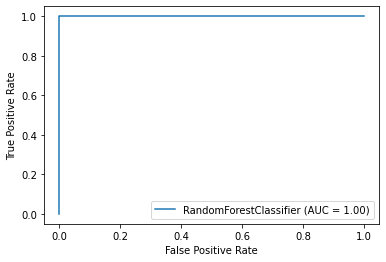

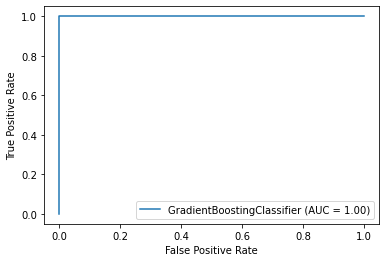

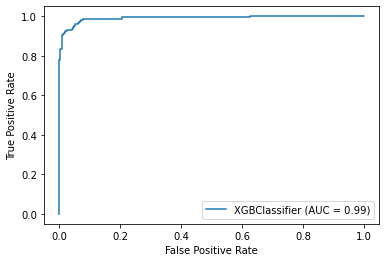

In [85]:
plot_roc_curve(random_forest_model,train, random_predict)
plot_roc_curve(gradient_model, train, gradient_predict)
plot_roc_curve(xgbc_model, train,gradient_predict)

  

# **6 - Validação Cruzada**
O quão confiável são as métricas obtidas nos modelos acima? Para isso faremos agora a etapa de validação, isto é, se os números são confiáveis ou se há algum enviesamento como o **overfitting**, que ocorre quando o modelo "decora" os dados e gera previsões ruins.

Dentre as várias técnicas possíveis, aplicaremos o K-Fold e o cross-validation (Validação cruzada).

o **K-fold cross-validation** divide aleatoriamente os dados em k grupos e em cada etapa etapa a validação é feita k vezes com os k grupos. Cada métrica final obtida é a média das métricas das k modelagens.
Os valores mais usados, baseado em vidência empírica, é de k=5 ou k=10, mas pode-se realizar testes para obter o melhor resultado.

Alguns artigos que consultei para compreender melhor:

[Cross Validation Explained: Evaluating estimator performance.
Improve your ML model using cross validation.](https://towardsdatascience.com/cross-validation-explained-evaluating-estimator-performance-e51e5430ff85)

[Understanding Cross Validation
How Cross Validation Helps Us Avoid The Pitfalls Of Overfitting](//https://towardsdatascience.com/understanding-cross-validation-419dbd47e9bd)

[Cross-Validation
Validating your Machine Learning Model Performance](https://towardsdatascience.com/cross-validation-c4fae714f1c5)

[CrossValidation de maneira didática](https://medium.com/data-hackers/crossvalidation-de-maneira-did%C3%A1tica-79c9b080a6ec)

[Cross-Validation in Machine Learning](https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f)



## **6.1 - Cross Validation para os modelos**
Desenvolveremos uma função para fazer a validação dos modelos e em seguida colocar no nosso DataFrame para comparação.

In [86]:
from sklearn.model_selection import KFold, cross_val_score

lista_de_modelos = [random_forest_model,gradient_model,xgbc_model]
media = []
desv_pad = []
intervalo = []

In [87]:
def validacao_cruzada(lista_de_modelos):
  
  #n_splits é a quantidade de divisão que será feita nos dados e testado
  #shuffle se prefere que embaralha os dados na escolha dos n_splits

  kfold  = KFold(n_splits=10, shuffle=True, random_state=2021)

  for x in lista_de_modelos:
    score = cross_val_score(x,train,target, cv=kfold, scoring='accuracy')
    #print((score*100).round(2),(score.mean()*100).round(2),(score.std()*100).round(2))
    media.append((score.mean()*100).round(2))
    desv_pad.append((score.std()*100).round(2))
    intervalo.append([(score.mean()*100).round(2) - (score.std()*100).round(2) , (score.mean()*100).round(2) + (score.std()*100).round(2)])


  tres_modelos["Acuracia-CV"]=media
  tres_modelos['Desvio Padrão-CV'] = desv_pad
  tres_modelos['Intervalo-CV'] =intervalo

  

In [88]:
validacao_cruzada(lista_de_modelos)
tres_modelos

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,Modelo,Acurácia,Precisão,Recall,F1-Score,Acuracia-CV,Desvio Padrão-CV,Intervalo-CV
0,Random Forest Classifier,97.98,97.93,96.78,97.35,81.60,4.06,"[77.53999999999999, 85.66]"
1,Gradient Boosting Model,94.39,95.34,89.77,92.47,82.27,4.64,"[77.63, 86.91]"
2,XGB Classifier,92.93,93.73,87.43,90.47,82.38,3.86,"[78.52, 86.24]"


**Notamos que com a validação cruzada a acurácia dos modelos diminuiu com média  inferior ao cálculo da acurácia, mas levando em conta os erros a partir dos desvio padrão, é mais provável que o valor esteja em algum ponto dentro do intervalo. Por exemplo, o Modelo XGB Classifier aplicado aos nossos dados tem uma acurácia entre 78,23% e 87,2%. Abaixo dos 92,93% calculado anteriormente**

## **6.2 - Comparando com os resultados obtido no Kaggle**
Submeti vários modelos desenvolvidos no Kaggle e obtivemos os resultados da imagem.
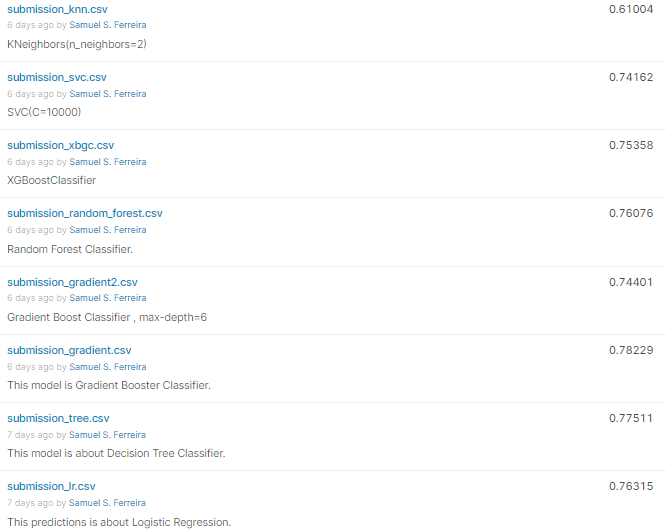


In [89]:
tres_modelos['Resultado do Kaggle'] = [76.77, 78.23, 75.36]
tres_modelos.sort_values(ascending=False, by= 'Resultado do Kaggle', ignore_index=True)

,Modelo,Acurácia,Precisão,Recall,F1-Score,Acuracia-CV,Desvio Padrão-CV,Intervalo-CV,Resultado do Kaggle
0,Gradient Boosting Model,94.39,95.34,89.77,92.47,82.27,4.64,"[77.63, 86.91]",78.23
1,Random Forest Classifier,97.98,97.93,96.78,97.35,81.60,4.06,"[77.53999999999999, 85.66]",76.77
2,XGB Classifier,92.93,93.73,87.43,90.47,82.38,3.86,"[78.52, 86.24]",75.36


**Observamos que o modelo que obteve melhor score com os dados de Teste foi o *Gradient Boost Model* que obteve 78,23% de score**
**Curiosamente, notamos que o score obtido no Kaggle está fora do intervalo, por uma pequena margem, da nossa validação obtida pelo K-Fold cross-validation para os modelos Gradient Boosting e XGB Classifier**


# **7 - Se eu tivesse viajado no Titanic, sobreviveria?**
## Conclusão

Aprendi bastante com o dessafio do Titanic. Consultei materiais, outras resoluções e em cada uma incorporei algo no meu notebook. Tentei aplicar outras funções e conceitos que aprendi mas nem tudo foi possível devido a limitação do dataset e porquê já estava consumindo horas e horas, ficando muito longo e cansativo.

Na Parte 1 - Seção 2 fizemos um reconhecimento do dataset train e tiramos algumas inferências sobre os passageiros do Titanic. Visualmente aferimos que alguns grupos tiveram maiores chances de sobreviver, por exemplo, mulheres, crianças, ser da 1ª Classe e viajar acompahado de um familiar. 
Posteriormente obtivemos a correlação entre as variáveis numéricas e concluimos que eram fracas e as mantivemos na confecção dos modelos.

Na Parte 2 - Seção 3 tratamos os dados faltantes manipulandoos e deixando-os preparados para entradas da seção 4.
Na Seção 4 Calculamos a acurácia de 9 modelos diferentes e as comparamos.Em sequência separamos os 3 com melhores desempenho e fizemos, na Seção 5, o cálculo das demais métricas e construímos o gráfico da Matriz de Confusão e curva ROC.

Não seção 6 fizemos a validação com o K-Fold cross-validation, comparando na tabela os intervalos das métricas anteriormente calculada.
Submetidas as previsões à competição do Kaggle, o melhor resultado obtido foi com o modelo GradientBooster que em nossas análises teve o segundo melhor desempenho.

## **Com suas características atuais, você teria sobrevivido ao Titanic?**

Vamos testar!



In [90]:
test.columns #para saber qual o vetor de características.

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_914',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [91]:
Samuel = np.array([1,0 , 33, 0, 0, 100, 0, 1, 0, 0]).reshape((1, -1))


# verificar se teríamos sobrevivido
a = gradient_model.predict(Samuel) 

if a == 1: 
    print('Você Sobreviveria ao Titanic!')
else:
    print('Que pena, você não teria muitas chances de sobreviver ao desastre do Titanic.')
     
     


Você Sobreviveria ao Titanic!


Se eu tivesse viajado sozinho na 1ª Classe, pago U$100 na época e embarcado em Cherbourg, teria dobrevivido.